In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import uniform
import itertools

In [2]:
import pickle
import pandas as pd

In [3]:
from utils import rayleigh_function, get_surface_data

In [4]:
from astropy.io import ascii

## Basic stuff

In [5]:
# the wavelengths
X = np.linspace(0.41, 2.35, 10000)

In [7]:
sun_transmission = get_surface_data(["data/cold_sun.csv"], X)[0]

In [8]:
# get earth transmission to surface 
earth_transmission_path = "data/Earth_Sun0.875_Surface"
wavelength, albedo = np.genfromtxt(earth_transmission_path, dtype=None, unpack=True)

earth_interp = interp1d(wavelength, albedo)
earth_transmission = earth_interp(X)*sun_transmission

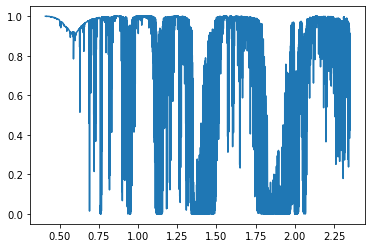

In [10]:
plt.plot(X, earth_interp(X))

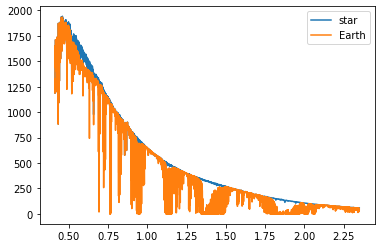

In [11]:
plt.plot(X, sun_transmission, label="star")
plt.plot(X, earth_transmission, label='Earth')
plt.legend()

## 6km cloud

0.4398400232288037


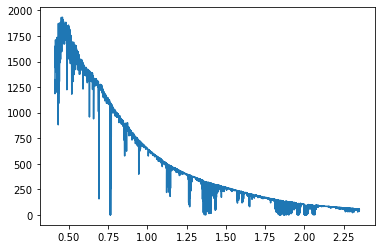

In [12]:
# get pressure at 6km
atmosphere_data_path = "data/clima_ColdEarth_Sun0.875"
atmosphere_data = ascii.read(atmosphere_data_path)
pressure_interp = interp1d(atmosphere_data['ALT'], atmosphere_data['P'])
pressure_6km = pressure_interp(6)
print(pressure_6km)

# get 6km cloud albedo
path_6km = "data/Earth_Sun0.875_6kmCloud"
wavelength, albedo = np.genfromtxt(path_6km, dtype=None, unpack=True)
interp_6km = interp1d(wavelength, albedo)
albedo_6km = interp_6km(X)
transmission_6km = sun_transmission*albedo_6km
plt.plot(X, transmission_6km)

## Surface & Combinations

In [15]:
cloud_path = "data/cloud/cloud_all.csv"
snow_path = "data/melting_snow_1-16.9366.asc"
sand_path = "data/quartz_gds74.5830.asc"
seawater_path = "data/seawater_open_ocean_sw2.9627.asc"
basalt_path = "data/basalt_weathered_br93-43.7492.asc"
veg_path = "data/Agrococcus_KM349956.csv"

surface_paths = {"snow": snow_path, 
                 "sand": sand_path,
                 "seawater": seawater_path,
                 "basalt": basalt_path,
                 "veg": veg_path}
cloud_path = [cloud_path]

surface_data = get_surface_data(surface_paths.values(), X)
cloud_data = get_surface_data(cloud_path, X)

# 100% veg (snow) + earthlike veg (snow)

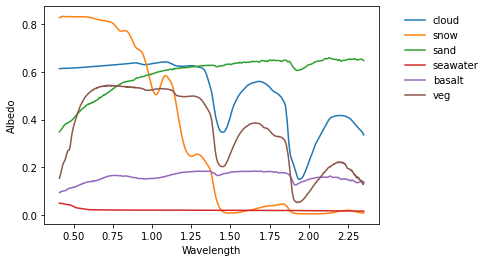

In [17]:
plt.plot(X, cloud_data.T, label='cloud')

for i, surface_name in enumerate(surface_paths.keys()):
    plt.plot(X, surface_data[i,:], label=surface_name)

plt.xlabel('Wavelength')
plt.ylabel('Albedo')
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1))

In [97]:
# NOTE: uncomment this section to generate all possible combinations
# of surfaces. This takes a little time to run. Should only ever need
# to run once.

# how many steps for each component
composition_steps = np.arange(0, 105, 5)
# create all possible combinations (note: can be greater than 100 here)
surface_combinations_iter = itertools.product(composition_steps, repeat=6)
# convert to numpy array
surface_combinations = np.array(list(surface_combinations_iter))
# get combinations that sums to 100, and renormalize to 1
# this is what we want
unity_surface_combinations = surface_combinations[np.where(np.sum(surface_combinations, axis = 1) == 100)[0]]/100

# component names
component_names = ['cloud'] + list( surface_paths.keys() )

# save data so we don't have to do this again
pickle.dump([component_names, unity_surface_combinations], open("output/surface_combinations.pkl", "wb"))

In [98]:
unity_surface_combinations

array([[0.  , 0.  , 0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.  , 0.  , 0.05, 0.95],
       [0.  , 0.  , 0.  , 0.  , 0.1 , 0.9 ],
       ...,
       [0.95, 0.  , 0.05, 0.  , 0.  , 0.  ],
       [0.95, 0.05, 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

In [99]:
# load all component combinations that sum to unity
component_names, unity_surface_combinations = pickle.load(open("output/surface_combinations.pkl", "rb"))

In [81]:
def make_all_spectra(X, combinations, cloud_index,
                     surfaces_albedo, cloud_albedo,
                     transmission_surface, transmission_6km,
                     p_6km,
                     star_spectrum):
    """
        Create spectra at given wavelengths, given combinations
        of components.
        
        Parameters:
            X (array): the wavelengths where flux are eval.
            combinations (array): array of combinations of
                components.
            cloud_index (int): which component in combinations is
                the cloud
            surfaces_albedo (array): array of albedo components 
                at surface
            cloud_alebdo (array): array of 6 km cloud albedo
            transmission_surface (array): transmission at surface
                (note: already multiplied by star spectrum)
            transmission_6km (array): transmission at 6km
                (note: already multiplied by star spectrum)
            p_6km (float): pressure at 6 km
            star_spectrum (array): spectrum of the star
        
        Returns
            (array): array of flux. shape is (ncombinations, X.size)
            
    """
    # separate combinations into surface and cloud
    surface_combinations = np.delete(combinations, cloud_index, axis=1)
    cloud_composition =  combinations[:,cloud_index]
    # reshape so we can do matrix multiplication later
    cloud_composition = cloud_composition.reshape(cloud_composition.shape[0], 1)
    
    # surface flux
    weighted_surface_albedos = surface_combinations.dot(surfaces_albedo)
    rayleigh_surface = rayleigh_function(X, star_spectrum, p=1.)
    flux_surface = transmission_surface*weighted_surface_albedos + rayleigh_surface
    
    # cloud only at 6km
    weighted_6km = cloud_composition.dot(cloud_albedo)
    rayleigh_6km = rayleigh_function(X, star_spectrum, p=p_6km)
    flux_cloud = transmission_6km*weighted_6km + rayleigh_6km
    
    # total flux
    flux = flux_surface + flux_cloud

    return flux

In [82]:
all_spectra = make_all_spectra(X, combinations = unity_surface_combinations, 
                               cloud_index = component_names.index("cloud"),
                               surfaces_albedo = surface_data, cloud_albedo = cloud_data,
                               transmission_surface = earth_transmission,
                               transmission_6km = transmission_6km,
                               p_6km = pressure_6km,
                               star_spectrum = sun_transmission)

In [83]:
unity_surface_combinations_df = pd.DataFrame(unity_surface_combinations, 
                                             columns=component_names)

In [84]:
unity_surface_combinations_df

,cloud,snow,sand,seawater,basalt,veg
0,0.00,0.00,0.00,0.00,0.00,1.00
1,0.00,0.00,0.00,0.00,0.05,0.95
2,0.00,0.00,0.00,0.00,0.10,0.90
3,0.00,0.00,0.00,0.00,0.15,0.85
4,0.00,0.00,0.00,0.00,0.20,0.80
...,...,...,...,...,...,...
53125,0.95,0.00,0.00,0.00,0.05,0.00
53126,0.95,0.00,0.00,0.05,0.00,0.00
53127,0.95,0.00,0.05,0.00,0.00,0.00
53128,0.95,0.05,0.00,0.00,0.00,0.00


In [93]:
# save spectra data
pickle.dump(all_spectra, open("output/all_spectra.pkl", "wb"))

## Make fake filters

In [26]:
FILTER_SIZE = 0.2 # in micron
FILTER_MIN  = 0.45 # starting wavelength
FILTER_MAX  = 2.35 # final wavelength

In [27]:
N_FILTERS = int(np.floor((FILTER_MAX - FILTER_MIN)/FILTER_SIZE))

In [28]:
def filter_func(initial, x, step=FILTER_SIZE):
    output = np.zeros(len(x))
    inrange = (x >= initial) & (x < initial + step)
    
    output[inrange] = 1
    output[~inrange] = 0
    return output

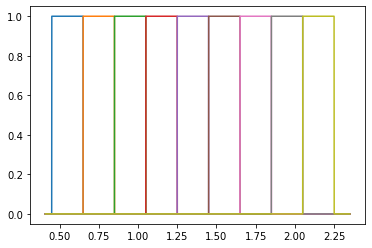

In [29]:
for i in range(N_FILTERS):
    filter_pos = FILTER_MIN + FILTER_SIZE*(i)
    filter_response = filter_func(filter_pos, X, step=FILTER_SIZE)
    plt.plot(X, filter_response)

In [86]:
colors = np.zeros((N_FILTERS, len(all_spectra)))

for i in range(N_FILTERS):
    filter_pos = FILTER_MIN + FILTER_SIZE*(i)
    filter_response = filter_func(filter_pos, X, step=FILTER_SIZE) * all_spectra
    print(filter_pos)
    colors[i] = np.trapz(filter_response, x=X, axis=1)

0.45
0.65
0.8500000000000001
1.05
1.25
1.45
1.6500000000000001
1.85
2.0500000000000003


In [87]:
colors = colors.transpose()

In [100]:
filter_names = [f"f{i}" for i in range(N_FILTERS)]

In [102]:
# save colors data
pickle.dump((filter_names, colors), open("output/colors_f1.pkl", "wb"))

In [89]:
unity_surface_combinations_df[(unity_surface_combinations_df['seawater'] > 0)]

,cloud,snow,sand,seawater,basalt,veg
21,0.00,0.00,0.00,0.05,0.00,0.95
22,0.00,0.00,0.00,0.05,0.05,0.90
23,0.00,0.00,0.00,0.05,0.10,0.85
24,0.00,0.00,0.00,0.05,0.15,0.80
25,0.00,0.00,0.00,0.05,0.20,0.75
...,...,...,...,...,...,...
53113,0.90,0.00,0.00,0.05,0.05,0.00
53114,0.90,0.00,0.00,0.10,0.00,0.00
53117,0.90,0.00,0.05,0.05,0.00,0.00
53121,0.90,0.05,0.00,0.05,0.00,0.00


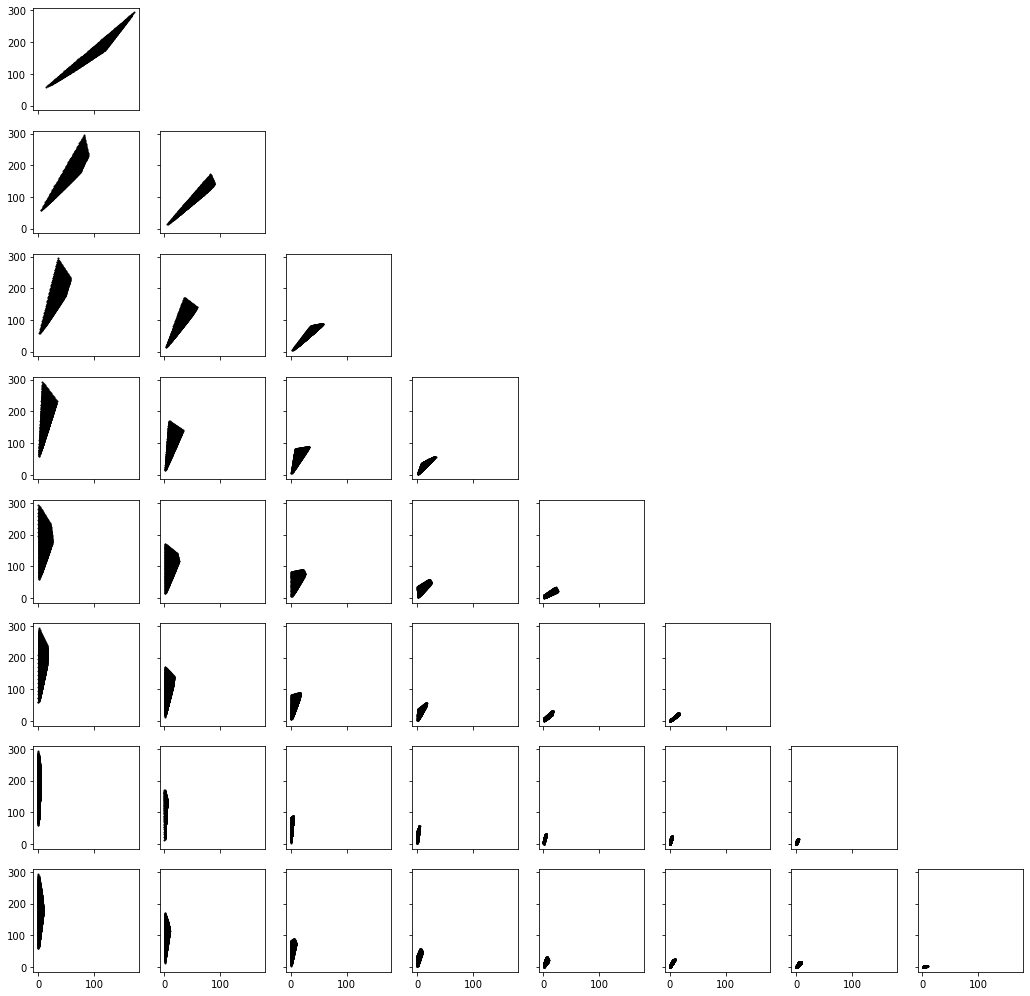

In [96]:
has_water = colors[(unity_surface_combinations_df['seawater'] > 0)]
fig, axes = plt.subplots(nrows=N_FILTERS, ncols=N_FILTERS, figsize=(20, 20), sharey=True, sharex=True)
for i in range(N_FILTERS):
    for j in range(N_FILTERS):
        if i > j:
            axes[i,j].scatter(has_water[:,i], has_water[:,j], s=1, c='k')
#         elif i == j:
#             axes[i,j].hist(has_water[:,i], bins=100)
        else:
            axes[i,j].remove()